In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon':True})

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor

from IPython.display import clear_output

# Loads

In [2]:
data = {}
for ville in ['paris', 'lyon', 'toulouse', 'nantes', 'bordeaux']:
    df = pd.read_csv('csv/%s.csv'%ville)
    X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)
    data[ville] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}

# Global

## metrics

In [3]:
REGR_METRICS = [
    ('r2', lambda x, y, z: r2_score(x, y)),
    ('ar2', lambda x, y, z: 1-(1-r2_score(x, y))*((len(x)-1)/(len(x)-z-1))),
    ('mae', lambda x, y, z: mean_absolute_error(x, y) / y.mean()),
    ('mse', lambda x, y, z: mean_squared_error(x, y) / (y.mean()**2)),
    ('rmse', lambda x, y, z: mean_squared_error(x, y, squared=False) / y.mean())
]

In [4]:
def get_metrics(y_test, y_pred, n_features):
    metrics = []
    for metric in REGR_METRICS:
        metrics.append(metric[1](y_test, y_pred, n_features))
    return metrics

## params

In [5]:
PARAMS = [
    {'loss':['squared_loss', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty':['l2', 'l1', 'elasticnet'],
    'alpha':[.01, .001, .0001, .00001],
    'l1_ratio':[0.1, .15, .5, .75, .9]}
]

## multi search

In [6]:
def multi_search(params, X_train, X_test, y_train, y_test, features, msg=''):
    full_params = {'max_iter':1e5, 'random_state':0}
    metrics = []
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
    for p in params:
        search = GridSearchCV(SGDRegressor(**full_params), p, n_jobs=4, cv=5, verbose=1).fit(X_train[features], y_train)
        full_params.update(search.best_params_)
        y_pred = search.best_estimator_.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        i+=1
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, len(params), i / len(params) * 100, msg))
        print(search.best_params_)
        print(search.best_estimator_.get_params())
    return full_params, metrics

## n_row

In [7]:
def n_row_search(params, X_train, X_test, y_train, y_test, features, row_step=10, msg=''):
    metrics = []
    row_count = len(y_train)
    search = np.empty((int(np.ceil(row_count/row_step)), len(REGR_METRICS)))
    i = 0
    print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    while i < row_count:
        i = min(i + row_step, row_count)
        model = SGDRegressor(**params).fit(X_train[features][:i], y_train[:i])
        y_pred = model.predict(X_test[features])
        metrics.append(get_metrics(y_test, y_pred, len(features)))
        clear_output(wait=True)
        print('{}/{} - {:.2f} - {}'.format(i, row_count, i / row_count * 100, msg))
    return (metrics, model.coef_)

## plot search

In [8]:
def plot_searchs(params, grid_metrics, n_row_metrics, coefs, features):
    print("\nModel Report\n")
    print('Coefs : %s\n'%coefs)
    print('Features : %s\n'%features)
    print('Params : %s\n'%params)
    print('R2 : %s'%np.max(grid_metrics[:,0]))
    print('AR2 : %s'%np.max(grid_metrics[:,1]))
    print('MAE/MEAN : %s'%np.min(grid_metrics[:,2]))
    print('MSE/MEAN² : %s'%np.min(grid_metrics[:,3]))
    print('RMSE/MEAN : %s'%np.min(grid_metrics[:,4]))
    
    fig, axs = plt.subplots(1,2, figsize=(20,5))
    fig.suptitle('Perfomance of the model')
    axs[0].plot(np.arange(grid_metrics.shape[0]), grid_metrics[:,0])
    axs[0].set_title('GridSearch R² evolution')
    axs[1].plot(np.arange(n_row_metrics.shape[0]), n_row_metrics[:,0])
    axs[1].set_title('n_row R² evolution')
    plt.show()
    

## plot model

In [9]:
def plot_pred(params, X_train, X_test, y_train, y_test, features):
    y_pred = SGDRegressor(**params).fit(X_train[features], y_train).predict(X_test[features])
    res = pd.DataFrame([(y_test.to_numpy()[i], y_pred[i]) for i in range(len(y_test))], columns=['true', 'pred']).sort_values('true')
    res['pred-mae'] = res['pred'] - mean_absolute_error(y_test, y_pred)
    res['pred+mae'] = res['pred'] + mean_absolute_error(y_test, y_pred)
#     print(res)
    plt.plot(np.arange(len(res)), res['true'])
    plt.plot(np.arange(len(res)), res['pred'])
    plt.show()


# Without query

In [10]:
features = list(df.columns[1:14])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, coefs = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'coefs':coefs})

70/70 - 100.00 - bordeaux


paris


Model Report

Coefs : [ 7.82687546 14.69714686  0.          0.92349509  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'l1'}

R2 : -2574.3934083370973
AR2 : -2808.520081822288
MAE/MEAN : 0.9568568273142566
MSE/MEAN² : 1.119265669565557
RMSE/MEAN : 1.0579535290198512


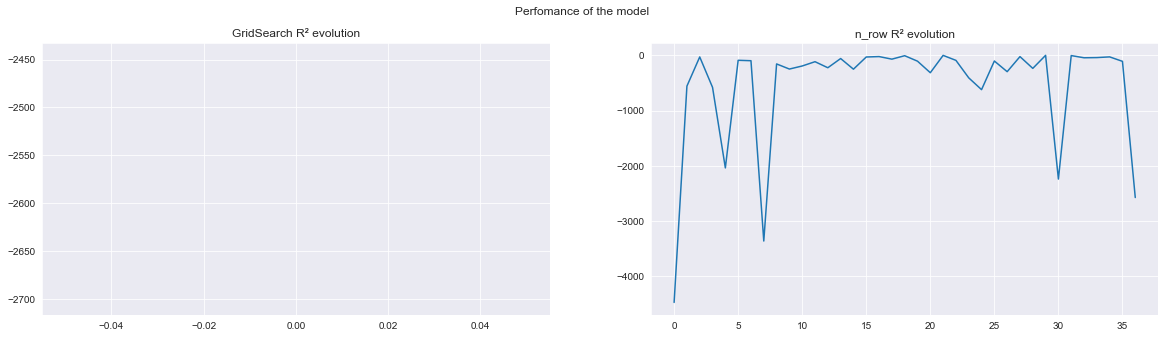

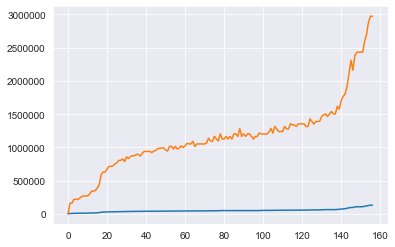

lyon


Model Report

Coefs : [-3.53515848  1.73608758  0.          0.60614993  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.9, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -53.00715728014733
AR2 : -73.6569527107919
MAE/MEAN : -1.4661924772578874
MSE/MEAN² : 2.496778178506799
RMSE/MEAN : -1.5801196722105575


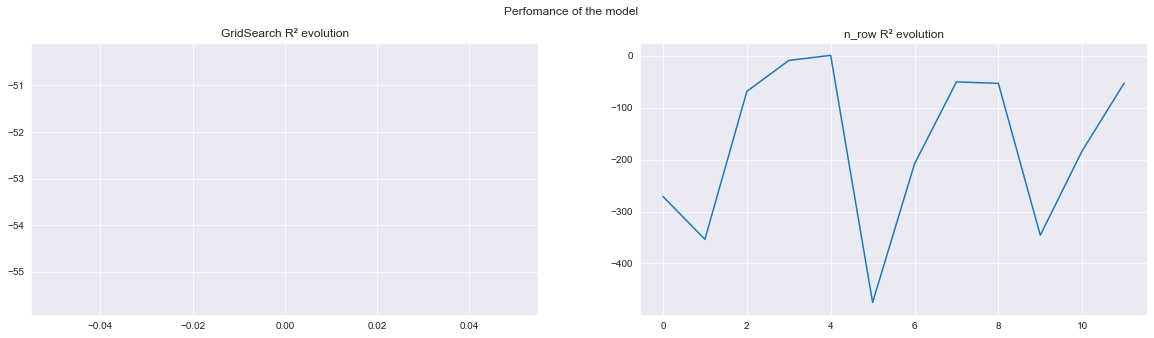

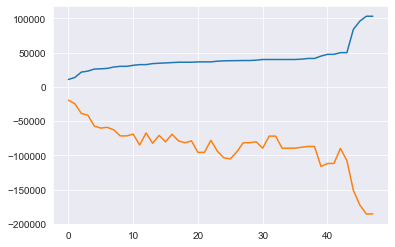

toulouse


Model Report

Coefs : [-3.51521885e+00 -2.31990683e-01 -1.55896468e-02 -1.00042227e+00
  0.00000000e+00 -3.40475027e-04 -4.12915933e-03  1.83808012e-04
  0.00000000e+00  0.00000000e+00 -1.74565672e-03  1.73413388e-03
  0.00000000e+00]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'l2'}

R2 : -309.2102715389877
AR2 : -712.4836245396716
MAE/MEAN : -1.240136858365499
MSE/MEAN² : 1.6963499117418592
RMSE/MEAN : -1.3024399839308756


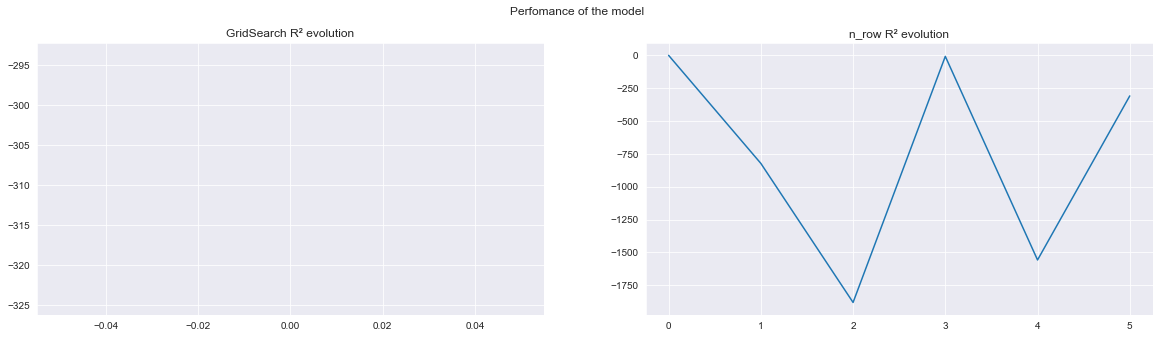

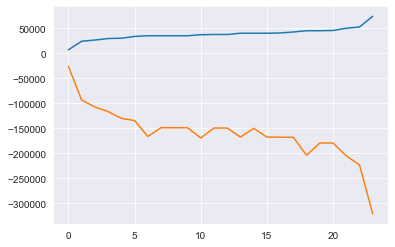

nantes


Model Report

Coefs : [-7.46802092  3.03068621 -0.01009798  0.7177106   0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -404.3983194747891
AR2 : -521.5133895452838
MAE/MEAN : -1.1882698678942039
MSE/MEAN² : 1.5447106784119229
RMSE/MEAN : -1.2428639018057943


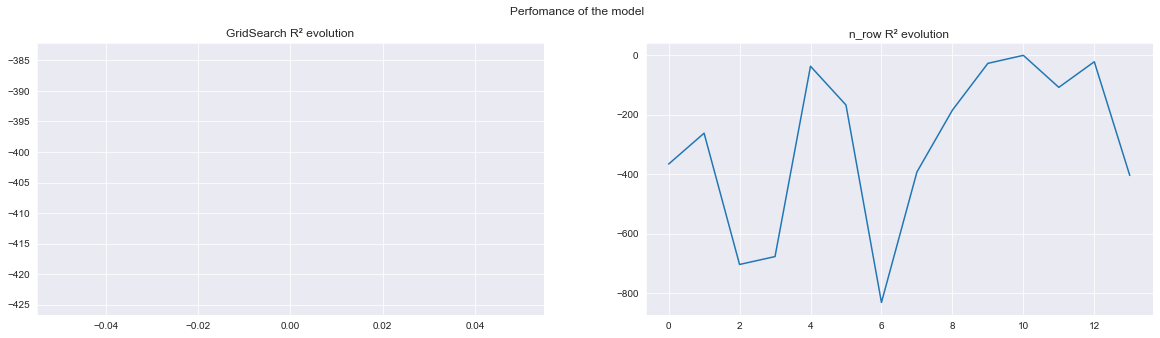

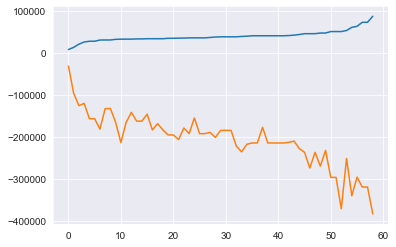

bordeaux


Model Report

Coefs : [ 7.26512813e+00 -1.30166990e+00 -1.35296743e-03  3.34331604e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -387.0545709372422
AR2 : -683.802184006898
MAE/MEAN : 0.8537656037648114
MSE/MEAN² : 0.7949694462235173
RMSE/MEAN : 0.8916105911346709


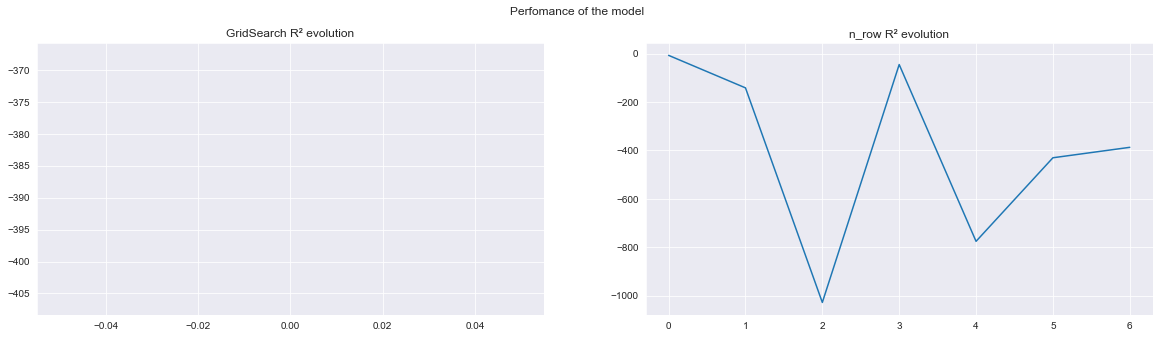

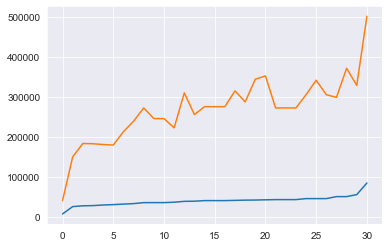

In [11]:
features = list(df.columns[1:14])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['coefs'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# With query

In [12]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, coefs = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'coefs':coefs})

70/70 - 100.00 - bordeaux


paris


Model Report

Coefs : [ 7.82687546 14.69714686  0.          0.92349509  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'l1'}

R2 : -2574.3934083370973
AR2 : -2931.5647569385924
MAE/MEAN : 0.9568568273142566
MSE/MEAN² : 1.119265669565557
RMSE/MEAN : 1.0579535290198512


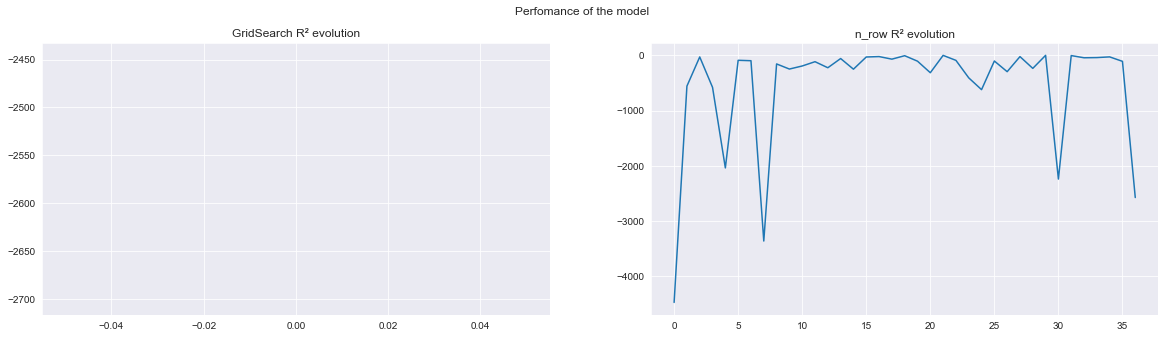

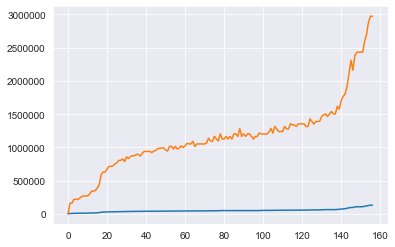

lyon


Model Report

Coefs : [-3.53515848  1.73608758  0.          0.60614993  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.9, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -53.00715728014733
AR2 : -89.65487114881874
MAE/MEAN : -1.4661924772578874
MSE/MEAN² : 2.496778178506799
RMSE/MEAN : -1.5801196722105575


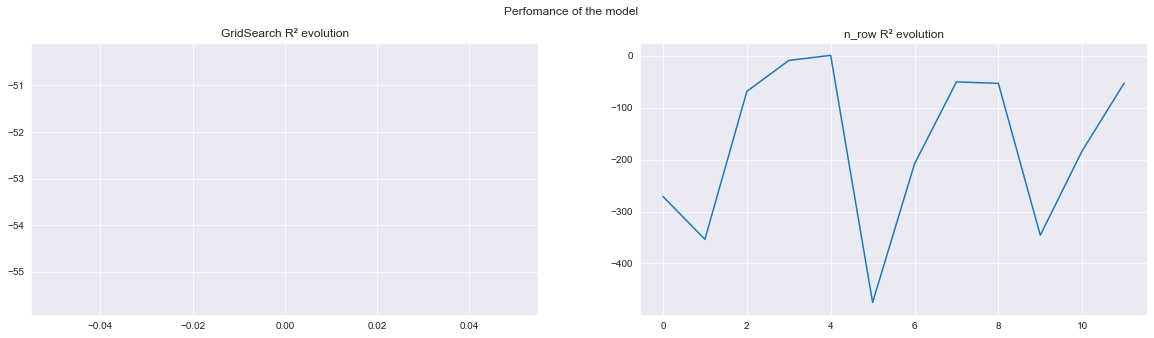

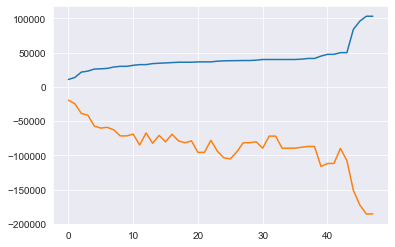

toulouse


Model Report

Coefs : [-3.51521885e+00 -2.31990683e-01 -1.55896468e-02 -1.00042227e+00
  0.00000000e+00 -3.40475027e-04 -4.12915933e-03  1.83808012e-04
  0.00000000e+00  0.00000000e+00 -1.74565672e-03  1.73413388e-03
  0.00000000e+00 -1.83493683e-03  0.00000000e+00  1.17291279e-03
 -2.70598715e-03 -7.70141451e-04  4.67349775e-03]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'l2'}

R2 : -309.21026078611044
AR2 : -1782.708999520135
MAE/MEAN : -1.2401368641489852
MSE/MEAN² : 1.6963499346511668
RMSE/MEAN : -1.3024399927256407


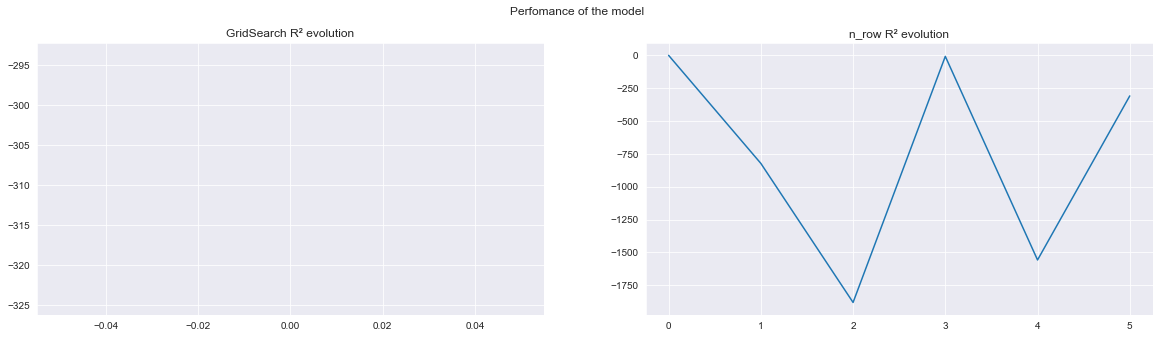

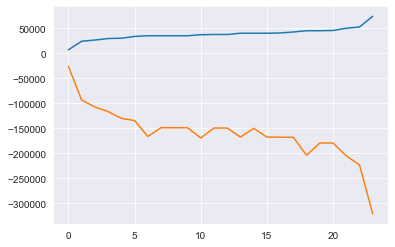

nantes


Model Report

Coefs : [-7.46802092  3.03068621 -0.01009798  0.7177106   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -404.3983194747891
AR2 : -601.9000648599427
MAE/MEAN : -1.1882698678942039
MSE/MEAN² : 1.5447106784119229
RMSE/MEAN : -1.2428639018057943


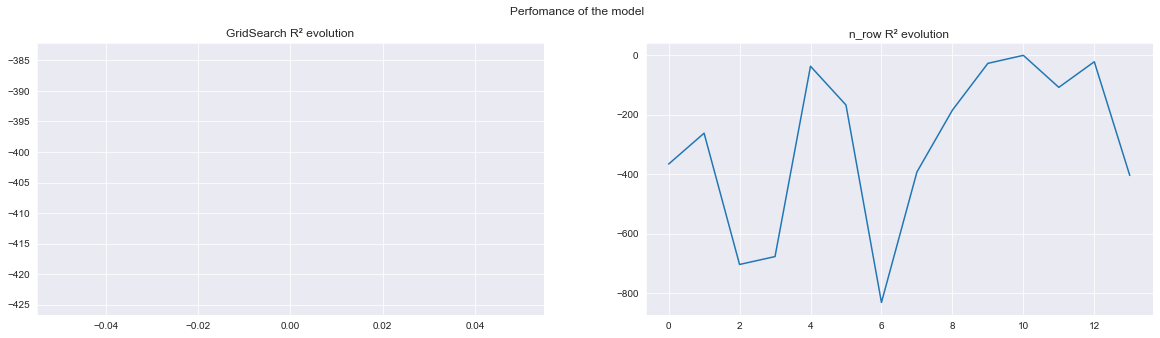

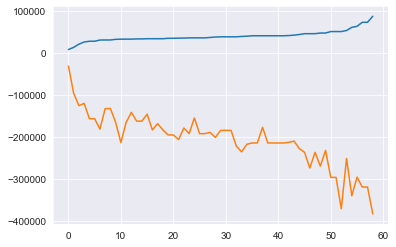

bordeaux


Model Report

Coefs : [ 7.26512813e+00 -1.30166990e+00 -1.35296743e-03  3.34331604e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -387.0545709372422
AR2 : -1057.3306480106605
MAE/MEAN : 0.8537656037648114
MSE/MEAN² : 0.7949694462235173
RMSE/MEAN : 0.8916105911346

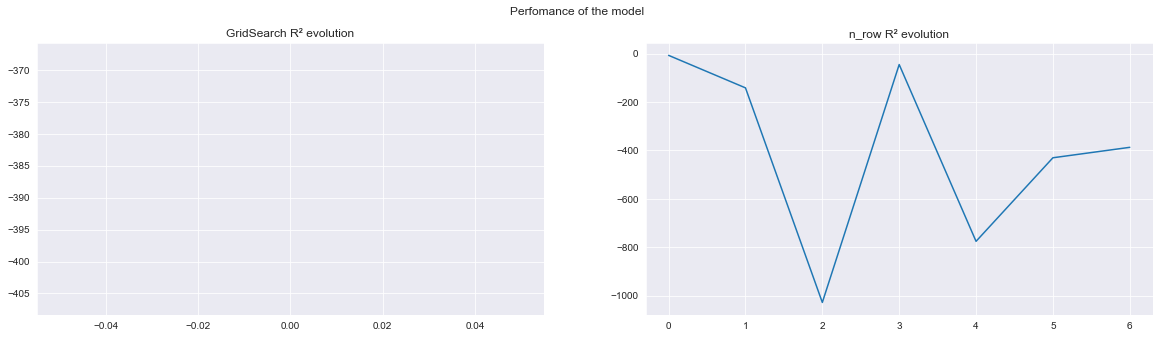

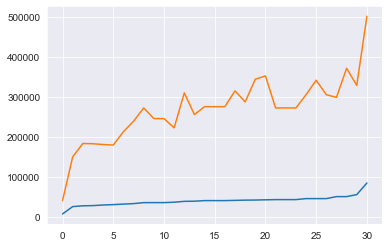

In [13]:
features = list(df.columns[1:14]) + list(df.columns[18:])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['coefs'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# Without ratings

In [14]:
list(df.columns[3:14]) + list(df.columns[18:])
for key, value in data.items():
    clear_output(wait=True)
    params, grid_metrics = multi_search(PARAMS, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    n_row_metrics, coefs = n_row_search(params, value['X_train'], value['X_test'], value['y_train'], value['y_test'], features, msg=key)
    data[key].update({'params':params, 'grid_metrics':grid_metrics, 'n_row_metrics':n_row_metrics, 'coefs':coefs})

70/70 - 100.00 - bordeaux


paris


Model Report

Coefs : [ 7.82687546 14.69714686  0.          0.92349509  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'l1'}

R2 : -2574.3934083370973
AR2 : -2931.5647569385924
MAE/MEAN : 0.9568568273142566
MSE/MEAN² : 1.119265669565557
RMSE/MEAN : 1.0579535290198512


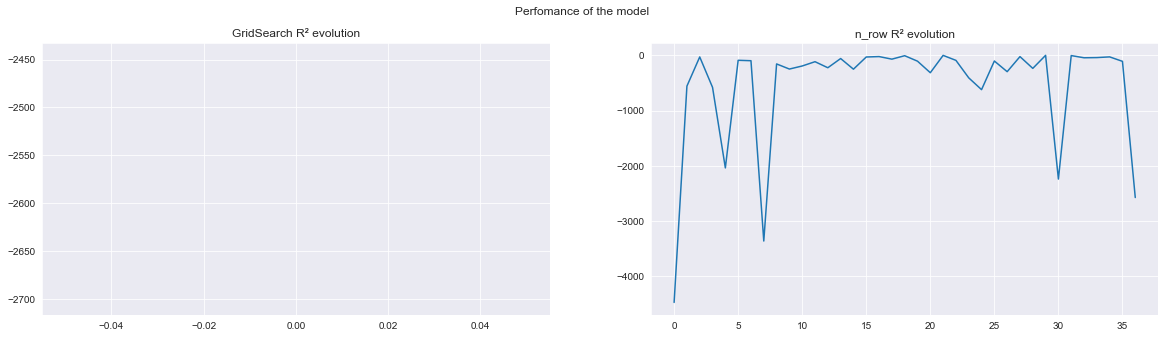

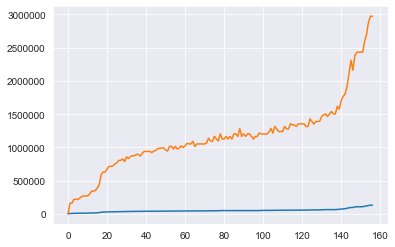

lyon


Model Report

Coefs : [-3.53515848  1.73608758  0.          0.60614993  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.9, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -53.00715728014733
AR2 : -89.65487114881874
MAE/MEAN : -1.4661924772578874
MSE/MEAN² : 2.496778178506799
RMSE/MEAN : -1.5801196722105575


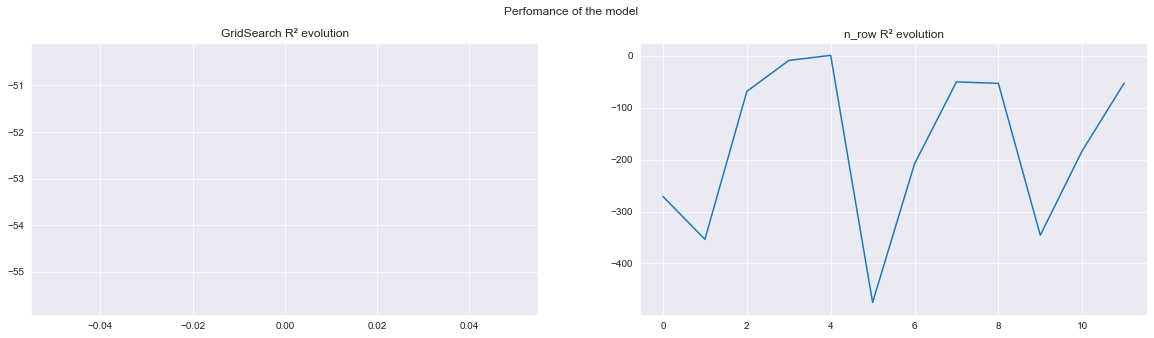

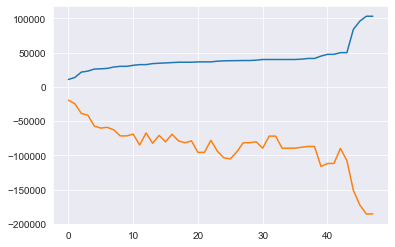

toulouse


Model Report

Coefs : [-3.51521885e+00 -2.31990683e-01 -1.55896468e-02 -1.00042227e+00
  0.00000000e+00 -3.40475027e-04 -4.12915933e-03  1.83808012e-04
  0.00000000e+00  0.00000000e+00 -1.74565672e-03  1.73413388e-03
  0.00000000e+00 -1.83493683e-03  0.00000000e+00  1.17291279e-03
 -2.70598715e-03 -7.70141451e-04  4.67349775e-03]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'l2'}

R2 : -309.21026078611044
AR2 : -1782.708999520135
MAE/MEAN : -1.2401368641489852
MSE/MEAN² : 1.6963499346511668
RMSE/MEAN : -1.3024399927256407


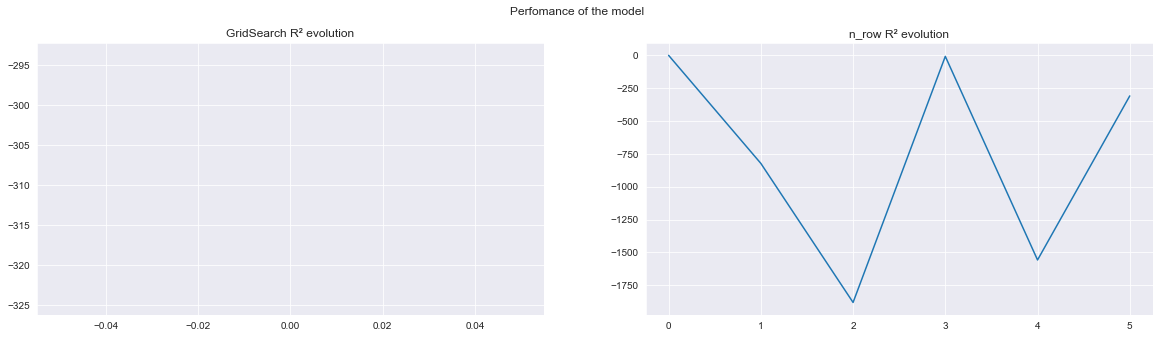

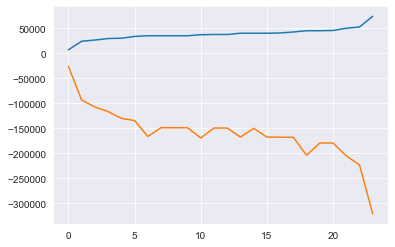

nantes


Model Report

Coefs : [-7.46802092  3.03068621 -0.01009798  0.7177106   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.1, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -404.3983194747891
AR2 : -601.9000648599427
MAE/MEAN : -1.1882698678942039
MSE/MEAN² : 1.5447106784119229
RMSE/MEAN : -1.2428639018057943


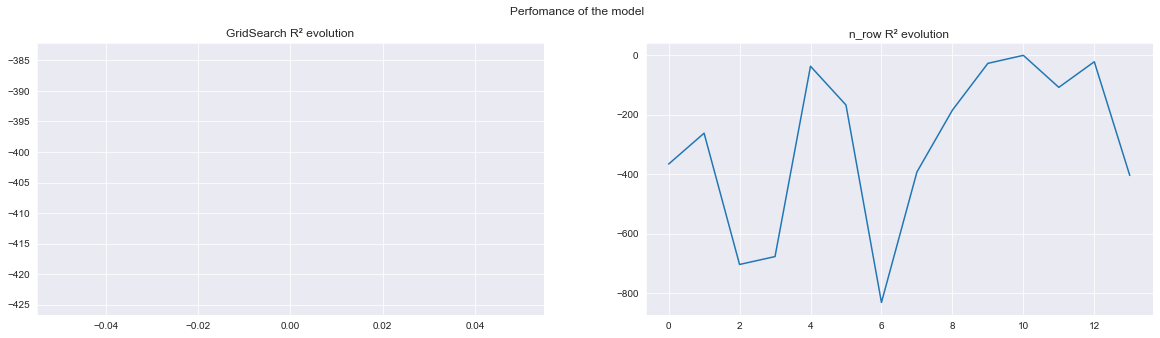

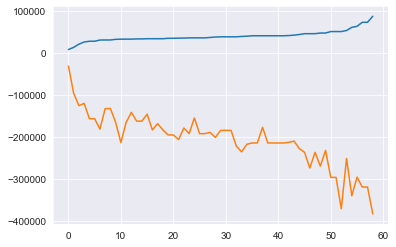

bordeaux


Model Report

Coefs : [ 7.26512813e+00 -1.30166990e+00 -1.35296743e-03  3.34331604e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.01, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -387.0545709372422
AR2 : -1057.3306480106605
MAE/MEAN : 0.8537656037648114
MSE/MEAN² : 0.7949694462235173
RMSE/MEAN : 0.8916105911346

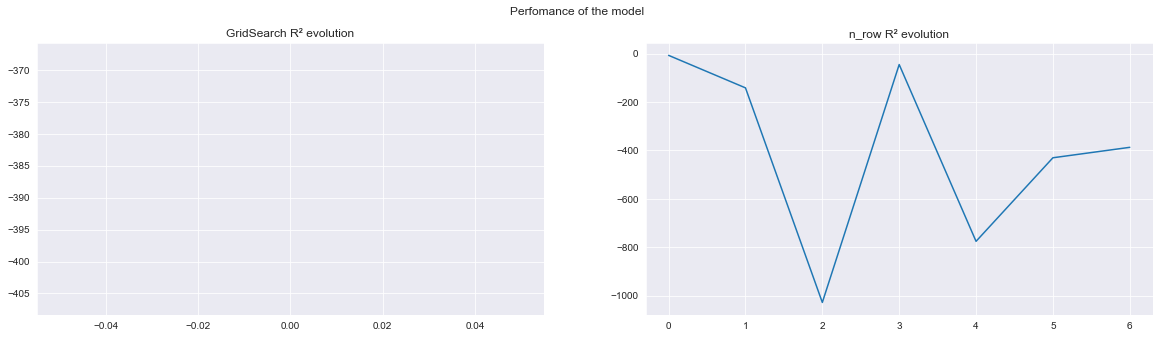

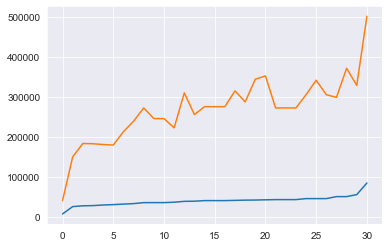

In [15]:
list(df.columns[3:14]) + list(df.columns[18:])
for key, value in data.items():
    print('{}\n'.format(key))
    plot_searchs(value['params'], np.array(value['grid_metrics']), np.array(value['n_row_metrics']), value['coefs'], features)
    plot_pred(value['params'], value['X_train'], value['X_test'], value['y_train'], value['y_test'], features)

# Paris work 

In [16]:
df = pd.read_csv('csv/paris.csv')
df = df[df['salary_mean']>1000]
df.info()
X_train, X_test, y_train, y_test = train_test_split(df, df['salary_mean'], test_size=.3, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 0 to 522
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   salary_min                   521 non-null    float64
 1   salary_max                   521 non-null    float64
 2   salary_mean                  521 non-null    float64
 3   rating_mean                  521 non-null    float64
 4   rating_count                 521 non-null    int64  
 5   contract_contrat pro         521 non-null    int64  
 6   contract_intérim             521 non-null    int64  
 7   contract_temps plein         521 non-null    int64  
 8   contract_indépendant         521 non-null    int64  
 9   contract_cdd                 521 non-null    int64  
 10  contract_temps partiel       521 non-null    int64  
 11  contract_cdi                 521 non-null    int64  
 12  contract_stage               521 non-null    int64  
 13  contract_commission 

## without query

In [17]:
features = list(df.columns[1:14])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg='paris2')
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Coefs : [-0.94439622  7.34355496  0.          1.13176409  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.001, 'l1_ratio': 0.9, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -150.86909030027164
AR2 : -164.67537123665994
MAE/MEAN : 0.8414282433854715
MSE/MEAN² : 0.8742397010511441
RMSE/MEAN : 0.9350078614916264


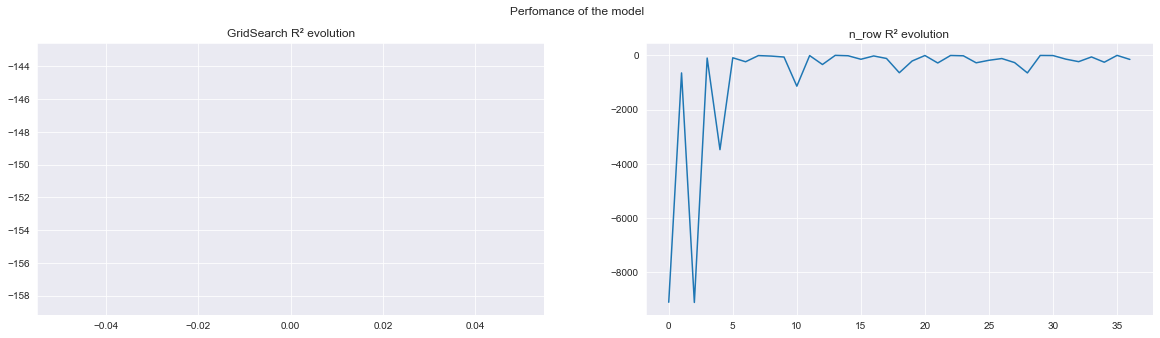

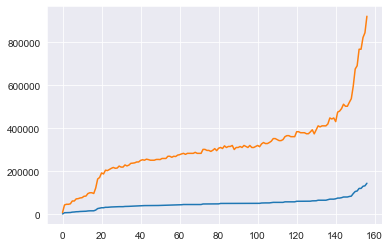

In [18]:
features = list(df.columns[1:14])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)

## with query

In [19]:
features = list(df.columns[1:14]) + list(df.columns[18:])

params, grid_metrics = multi_search(PARAMS, X_train, X_test, y_train, y_test, features, msg=key)
n_row_metrics, feature_importances = n_row_search(params, X_train, X_test, y_train, y_test, features, msg='paris2')

364/364 - 100.00 - paris2



Model Report

Coefs : [-0.94439622  7.34355496  0.          1.13176409  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]

Features : ['salary_max', 'salary_mean', 'rating_mean', 'rating_count', 'contract_contrat pro', 'contract_intérim', 'contract_temps plein', 'contract_indépendant', 'contract_cdd', 'contract_temps partiel', 'contract_cdi', 'contract_stage', 'contract_commission', 'mode_mois', 'mode_semaine', 'query_data+scientist', 'query_business+intelligence', 'query_data+analyst', 'query_developpeur']

Params : {'max_iter': 100000.0, 'random_state': 0, 'alpha': 0.001, 'l1_ratio': 0.9, 'loss': 'huber', 'penalty': 'elasticnet'}

R2 : -150.86909030027164
AR2 : -171.9312269112582
MAE/MEAN : 0.8414282433854715
MSE/MEAN² : 0.8742397010511441
RMSE/MEAN : 0.9350078614916264


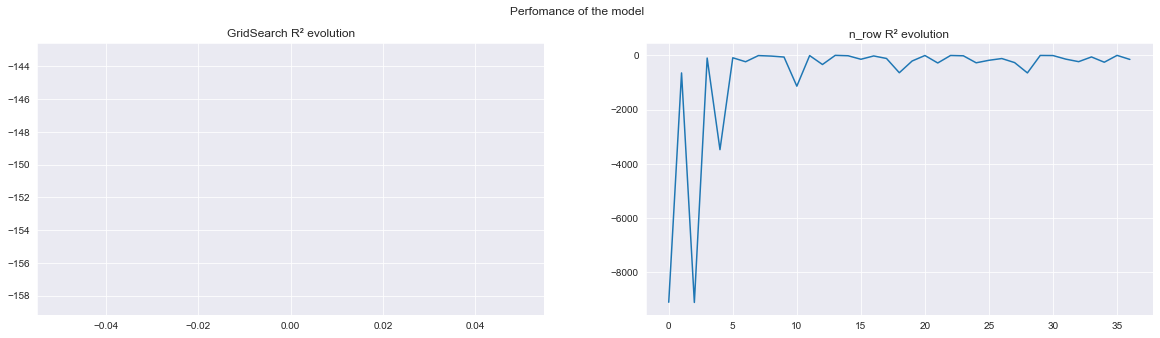

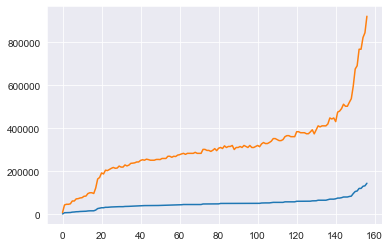

In [20]:
features = list(df.columns[1:14]) + list(df.columns[18:])

plot_searchs(params, np.array(grid_metrics), np.array(n_row_metrics), feature_importances, features)
plot_pred(params, X_train, X_test, y_train, y_test, features)